In [43]:
%load_ext autoreload 
import numpy as np
from tqdm import tqdm
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from copy import copy
from collections import defaultdict, Counter
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import SpectralClustering, DBSCAN
from sklearn_extra.cluster import KMedoids
from metric_learn import LMNN

from joblib import Parallel, delayed

from umap import UMAP
from hdbscan import validity_index as DBCV
from hdbscan import HDBSCAN
from clustering_utils import clustering_by_methods, clustering, plot_clustering_scatter
from utils import get_density, coord_to_pix

from IPython.display import clear_output

import warnings
warnings.simplefilter("ignore")
%autoreload 2

# see paper for the thresholds explanation
DBIND_THRESHOLD = 0.6
DBIND_MAX = 3.
SILHOUETTE_THRESH = 0.5

PS_THRESHOLD = 0.8
DBCV_THRESHOLD = 0.0

DATA_PRESERVED_THRESHOLD = 0.9

plt.rcParams.update({'font.size': 20, 'axes.titley':1.05})

N_CMAP = 256

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [10]:
CPT = 0.01 # minimal percentage of the data in single cluster
DATA_SPECIFICATION = '' #'_pat0.7'

clustering_results_root = f'results/clustering_cpt-{CPT}{DATA_SPECIFICATION}' #+ '_small_datasets'

if not os.path.exists(clustering_results_root):
    os.makedirs(clustering_results_root)

In [11]:
# datasets_names = ['Sanger', 'Illumina', 'Pyroseq']
# tax_names = ['g']

datasets_names = ['AGP', 'HMP']
tax_names = ['o', 'f', 'g']

data_orig = {}
for dataset_name in tqdm(datasets_names):
    for tax in tax_names: 
        dataframe = pd.read_csv(f'./data_processed{DATA_SPECIFICATION}/{dataset_name}_{tax}.csv', sep=',')
        label = f'{dataset_name}_{tax}'
        data_orig[label] = dataframe.drop('Unnamed: 0', axis=1).values
    
data_pca = {}
for dataset_name in tqdm(datasets_names):
    for tax in tax_names: 
        label = f'{dataset_name}_{tax}'
        data_pca[label] = np.genfromtxt(f'./results/pca{DATA_SPECIFICATION}/{label}', delimiter=';')
        
try:
    data_embeddings = defaultdict(dict)
    embeddings_path = f'./results/embeddings{DATA_SPECIFICATION}'

    for emb_path in glob.glob(embeddings_path + '/*'):
        label_info = emb_path.split('/')[-1].split('.')[0]
        dataset, tax, embedding_type = label_info.split('_')
        d = np.load(emb_path, allow_pickle=True).item()
        label = dataset + '_' + tax
        data_embeddings[embedding_type][label] = d['Z_']
except Exception as e:
    print(e)
    pass
    
distance_root = f'distances_processed{DATA_SPECIFICATION}'
distances_names = ['L1', 'L2', 'JS', 'BC']

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.10it/s]


In [12]:
clustering_results_root

'results/clustering_cpt-0.01'

In [5]:
!ls -la results/clustering_cpt-0.01/

total 8
drwxr-xr-x  2 ibulygin users 4096 апр 13 00:49 .
drwxr-xr-x 19 ibulygin users 4096 апр 13 00:49 ..


# Load synthetic data

In [4]:
# clustering_results_root = f'results/clustering_cpt-{CPT}_synthetic/'

# if not os.path.exists(clustering_results_root):
#     os.makedirs(clustering_results_root)

# targets_orig = {}
# for path in glob.glob('data/synthetic/*'):
#     dataframe = pd.read_csv(path, index_col=0)
#     label = path.split('/')[-1].split('.')[0]
#     targets_orig[label] = dataframe['target'].values
    
# data_orig = {}
# for path in glob.glob('data_processed/synthetic/*'):
#     dataframe = pd.read_csv(path, index_col=0)
#     label = path.split('/')[-1].split('.')[0]
#     data_orig[label] = dataframe.values

# data_pca = {}
# for path in tqdm(glob.glob('./results/pca/synthetic/*')):
#     label = path.split('/')[-1]
#     data_pca[label] = np.genfromtxt(path, delimiter = ';')
        
# data_embeddings = defaultdict(dict)
# embeddings_path = './results/embeddings_synthetic'
# inliers_indexes_all = {}
# for emb_path in glob.glob(embeddings_path + '/*'):
#     label_info = emb_path.split('/')[-1].split('.')[0]
#     dataset, tax, embedding_type = label_info.split('_')
#     d = np.load(emb_path, allow_pickle=True).item()
#     label = dataset + '_' + tax
#     data_embeddings[embedding_type][label] = d['Z_']
#     inliers_indexes_all[label_info] = d['inliers_indexes_mae']
    
# distance_root = 'distances_processed_synth'
# # only L1 and L2 distances are supported
# distances_names = ['L1', 'L2']

# Clustering: precomputed distances

In [13]:
distances_orig = defaultdict(dict)
for metric_name in distances_names:
    for label in data_orig.keys(): 
        distances_orig[metric_name][label] = np.load(os.path.join(distance_root,\
                                                                  f'orig_{metric_name}_{label}.npy'), 
                                                     allow_pickle=True)

In [14]:
class SpectralClustering_prec:
    def __init__(self, *args, **kwargs):
        self.method = SpectralClustering(*args, **kwargs, affinity='precomputed', random_state=42)
    def fit_predict(self, X):
        '''
        X - pairwise_distance matrix
        '''
        A = np.exp(-self.method.gamma * np.abs(X))
        return self.method.fit_predict(A)

In [15]:
methods_dict_distances = {
                           'HDBSCAN':[HDBSCAN, 
                              {'min_cluster_size':[5,10,25,50], 
                               'min_samples':[None,5,10,15,20],
                               'metric':['precomputed'],
                               'core_dist_n_jobs':[1],
                               'random_state':[42]}
                               ],
                           'KMedoids':[KMedoids, 
                                       {'n_clusters':np.arange(2, 10, 1),
                                        'method':['pam'],
                                        'metric':['precomputed'],
                                        'init':['k-medoids++'],
                                        'random_state':[42]}],
                           'SpectralClustering':[SpectralClustering_prec, 
                                                 {'n_clusters':np.arange(2, 10, 1), 
                                                  'gamma':[1., 5, 10, 15],
                                                  'eigen_tol':[1e-4]}]
                        }

In [16]:
for distance_name, distance_dict in tqdm(distances_orig.items()):
    
    results_path = os.path.join(clustering_results_root, f'{distance_name}_cluster_results')
    
#     if os.path.isfile(results_path + '.npy'):
#         print(f'{results_path} exists, skipping...')
#         continue
    
    distance_cluster_results = defaultdict(dict)
    
    '''
    list of dicts [
                  dataset_1 ->  {'method1':[partition1, partition2], ...}
                    , ...., 
                  dataset_n ->  {'method1':[partition1, partition2], ...}
                  ]
    
    '''
    clustering_data_results = Parallel(n_jobs=len(distance_dict),
                                       mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
                                                                                      methods_dict_distances,
                                                                                      precomputed=True,
                                                                                      d=data_orig[label].shape[1],
                                                                                      cluster_perc_threshold=CPT)
                                                            for label, data in distance_dict.items())


#     for label, data in distance_dict.items():
#         clustering_by_methods(data.astype('double'), 
#                               methods_dict_distances,
#                               precomputed=True,
#                               d=data_orig[label].shape[1],
#                               cluster_perc_threshold=CPT)

    # create compatible metrics dicts
    for i,label in enumerate(distance_dict.keys()):
        for j, method_name in enumerate(methods_dict_distances.keys()):
            distance_cluster_results[label][method_name] = clustering_data_results[i][method_name]

    np.save(results_path, distance_cluster_results)
    
clear_output()

# Clustering: PCA

In [6]:
methods_dict = {'HDBSCAN':[HDBSCAN, 
                          {'min_cluster_size':[5,10,25,50], 
                           'min_samples':[None,5,10,15,20],
                           'core_dist_n_jobs':[1]}],
               'KMedoids':[KMedoids, 
                           {'n_clusters':np.arange(2, 10, 1),
                            'method':['pam'],
                            'init':['k-medoids++'],
                            'random_state':[42]}],
               'SpectralClustering':[SpectralClustering, 
                                     {'n_clusters':np.arange(2, 10, 1), 
                                     'affinity':['nearest_neighbors'],
                                     'n_neighbors': [5, 15, 25, 50], 
                                     'eigen_tol':[1e-4],
                                     'random_state':[42]}]}

In [7]:
# ls -la results/clustering_cpt-0.01_small_datasets

In [ ]:
results_path = os.path.join(clustering_results_root, f'pca_cluster_results')

pca_cluster_results = defaultdict(dict)

clustering_data_results = Parallel(n_jobs=len(data_pca),
                                   mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
                                                                                  methods_dict,
                                                                                  precomputed=False,
                                                                                  d=data.shape[1],
                                                                                  cluster_perc_threshold=CPT)
                                                        for label, data in data_pca.items())

# create compatible metrics dicts
for i,label in enumerate(data_pca.keys()):
    for j, method_name in enumerate(methods_dict.keys()):
        pca_cluster_results[label][method_name] = clustering_data_results[i][method_name]

np.save(results_path, pca_cluster_results)

clear_output()

/home/ibulygin/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expecte

/home/ibulygin/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expecte

/home/ibulygin/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/ibulygin/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


# Clustering: embeddings 

In [17]:
for embedding_type, embeddings in tqdm(data_embeddings.items()):
    
    results_path = os.path.join(clustering_results_root, f'{embedding_type}_cluster_results')
    
    if os.path.isfile(results_path + '.npy'):
        print(f'{results_path} exists, skipping...')
        continue
    else:
        print(f'{results_path} exists, calculating...')
    
    embeddings_cluster_results = defaultdict(dict)
    
    '''
    list of dicts [
                  dataset_1 ->  {'method1':[partition1, partition2], ...}
                    , ...., 
                  dataset_n ->  {'method1':[partition1, partition2], ...}
                  ]
    
    '''
    clustering_data_results = Parallel(n_jobs=len(embeddings),
                                       mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
                                                                                      methods_dict,
                                                                                      precomputed=False,
                                                                                      d=data.shape[1],
                                                                                      cluster_perc_threshold=CPT)
                                                            for label, data in embeddings.items())

    # create compatible metrics dicts
    for i,label in enumerate(embeddings.keys()):
        for j, method_name in enumerate(methods_dict.keys()):
            embeddings_cluster_results[label][method_name] = clustering_data_results[i][method_name]

    np.save(results_path, embeddings_cluster_results)
    
clear_output()

# Synthetic data
uncomment all cells in this section to use code for figures generation

In [623]:
# # ['lle', 'L1', 'pca', ...]
# representations_names = np.unique(list(map(lambda x: x.split('_')[0], os.listdir(clustering_results_root))))

# clustering_results_df = []

# for representation in representations_names:
    
#     clustreing_results_path = os.path.join(clustering_results_root, f'{representation}_cluster_results.npy')
#     cluster_results = np.load(clustreing_results_path, allow_pickle=True).item()
    
#     # results for each datset
#     for label, cl_res_label in cluster_results.items():
#         #results for each method given dataset
#         for cl_method, cl_res_label_method in cl_res_label.items():
            
#             if len(cl_res_label_method) == 0:
#                 print('Empty results for:', representation, label, cl_method)
#                 continue
                
#             df = pd.DataFrame(cl_res_label_method)
            
#             df['label'] = label
#             df['representation'] = representation
#             df['cl_method'] = cl_method
#             # n_clusters found
            
#             # real clusters
#             y = targets_orig[label]
#             n_clusters_real = len(np.unique(y))
#             df['n_cl_real'] = n_clusters_real - 1 
            
#             # calculate Adjusted Rand Index and number of clusters
#             ari_s = []
#             n_cl_s = []
#             n_cl_real_s = []
#             for cl_res_label_method_i in cl_res_label_method:
#                 y_ = cl_res_label_method_i['labels']
#                 mask = cl_res_label_method_i['mask']
                
#                 # if it is a clustering for manifold-learning embedding
#                 if representation in data_embeddings.keys():
#                     inliers = inliers_indexes_all[label + '_' + representation]
#                 else:
#                     inliers = np.arange(len(y))
                    
#                 n_cl  = len(np.unique(y_))
#                 n_cl_s.append(n_cl)
                
#                 ari = adjusted_rand_score(y[inliers][mask], y_) 
#                 ari_s.append(ari)
                
#             df['ari'] = ari_s
#             df['n_cl'] = n_cl_s
            
#             clustering_results_df.append(df)
            
# clustering_results_df = pd.concat(clustering_results_df, axis=0, ignore_index=True)

In [624]:
# clustering_results_df_ = clustering_results_df.dropna()
# clustering_results_proper = clustering_results_df_.query('ari > 0.7 & (n_cl == n_cl_real)')
# assert len(np.unique(clustering_results_proper['label'])) == 9 # all datasets were partitioned properly

In [625]:
# len(clustering_results_proper.query(f'ps >= {PS_THRESHOLD} & dbcv > {DBCV_THRESHOLD}')['label'].unique())

In [626]:
# len(clustering_results_proper.query(f'dbind <= {DBIND_THRESHOLD} & silh > {SILHOUETTE_THRESH}')['label'].unique())

In [7]:
# plot_clustering_scatter(clustering_results_df_, 
#                         x_metric_name='dbind',
#                         y_metric_name='silh', 
#                         coloring_metric_name='entropy', 
#                         title='Synthetic datasets clustering',
#                         y_threshold=SILHOUETTE_THRESH,
#                         x_threshold=DBIND_THRESHOLD,
#                         y_hue_line=1,
#                         x_hue_line=0)

In [8]:
# ind = clustering_results_df_.query(f'silh >= {SILHOUETTE_THRESH} & dbind <= {DBIND_THRESHOLD} & ps > {PS_THRESHOLD}').groupby('label')['silh'].idxmax().values
# clustering_results_df_.loc[ind].query('n_cl_real == n_cl')

In [6]:
# plot_clustering_scatter(clustering_results_df_, 
#                         x_metric_name='dbcv',
#                         y_metric_name='ps', 
#                         coloring_metric_name='entropy', 
#                         title='Synthetic datasets clustering',
#                         y_threshold=PS_THRESHOLD,
#                         x_threshold=DBCV_THRESHOLD,
#                         y_hue_line=1.2,
#                         x_hue_line=1
#                         )

In [9]:
# ind = clustering_results_df_.query(f'dbcv >= {DBCV_THRESHOLD} & ps >= {PS_THRESHOLD} & data_used > {DATA_PRESERVED_THRESHOLD}').groupby('label')['dbcv'].idxmax().values
# clustering_results_df_.loc[ind].query('n_cl_real == n_cl')

In [18]:
clustering_results_root

'results/clustering_cpt-0.01'

In [21]:
ls -la results/clustering_cpt-0.01/

total 143152
drwxr-xr-x  2 ibulygin users     4096 апр 13 19:38 ./
drwxr-xr-x 19 ibulygin users     4096 апр 13 00:49 ../
-rw-r--r--  1 ibulygin users 13576666 апр 13 19:38 ae_cluster_results.npy
-rw-r--r--  1 ibulygin users 11391544 апр 13 16:38 BC_cluster_results.npy
-rw-r--r--  1 ibulygin users 14215427 апр 13 18:02 isomap_cluster_results.npy
-rw-r--r--  1 ibulygin users 12561772 апр 13 15:30 JS_cluster_results.npy
-rw-r--r--  1 ibulygin users  9228290 апр 13 13:15 L1_cluster_results.npy
-rw-r--r--  1 ibulygin users 10943694 апр 13 14:22 L2_cluster_results.npy
-rw-r--r--  1 ibulygin users 13613560 апр 13 17:09 lle_cluster_results.npy
-rw-r--r--  1 ibulygin users 15540956 апр 13 01:28 pca_cluster_results.npy
-rw-r--r--  1 ibulygin users 14199158 апр 13 18:58 spectral_cluster_results.npy
-rw-r--r--  1 ibulygin users 15280470 апр 13 17:35 tsne_cluster_results.npy
-rw-r--r--  1 ibulygin users 16003590 апр 13 18:28 umap_cluster_results.npy


# Microbiome data

In [22]:
# ['lle', 'L1', 'pca', ...]
representations_names = np.unique(list(map(lambda x: x.split('_')[0], os.listdir(clustering_results_root))))

clustering_results_df = []

for representation in representations_names:
    
    clustreing_results_path = os.path.join(clustering_results_root, f'{representation}_cluster_results.npy')
    cluster_results = np.load(clustreing_results_path, allow_pickle=True).item()
    
    # results for each datset
    for label, cl_res_label in cluster_results.items():
        #results for each method given dataset
        for cl_method, cl_res_label_method in cl_res_label.items():
            
            if len(cl_res_label_method) == 0:
                print('Empty results for:', representation, label, cl_method)
                continue
                
            df = pd.DataFrame(cl_res_label_method)
            
#             cl_res_label_method_ = {k:v[0] for k,v in cl_res_label_method.items()}
#             df = pd.DataFrame(cl_res_label_method_).T
            
            dataset, tax = label.split('_')
            
            df['dataset'] = dataset
            df['tax'] = tax
            df['representation'] = representation
            df['cl_method'] = cl_method
            # n_clusters found
            n_unique = lambda x: len(np.unique(x[x!=-1]))
            df['n_cl'] = df['labels'].apply(n_unique)
            
            clustering_results_df.append(df)
            
clustering_results_df = pd.concat(clustering_results_df, axis=0, ignore_index=True)

Empty results for: BC AGP_o HDBSCAN
Empty results for: BC AGP_f HDBSCAN
Empty results for: BC AGP_g HDBSCAN
Empty results for: BC HMP_f HDBSCAN
Empty results for: BC HMP_g HDBSCAN
Empty results for: JS AGP_o HDBSCAN
Empty results for: JS AGP_f HDBSCAN
Empty results for: JS AGP_g HDBSCAN
Empty results for: JS HMP_o HDBSCAN
Empty results for: JS HMP_f HDBSCAN
Empty results for: JS HMP_g HDBSCAN
Empty results for: L1 AGP_o HDBSCAN
Empty results for: L1 AGP_f HDBSCAN
Empty results for: L1 AGP_g HDBSCAN
Empty results for: L1 HMP_f HDBSCAN
Empty results for: L1 HMP_g HDBSCAN
Empty results for: L2 AGP_o HDBSCAN
Empty results for: L2 AGP_f HDBSCAN
Empty results for: L2 AGP_g HDBSCAN
Empty results for: L2 HMP_f HDBSCAN
Empty results for: L2 HMP_g HDBSCAN
Empty results for: ae AGP_f HDBSCAN
Empty results for: ae HMP_f HDBSCAN
Empty results for: ae HMP_g HDBSCAN
Empty results for: ae AGP_g HDBSCAN
Empty results for: ae AGP_o HDBSCAN
Empty results for: isomap AGP_f HDBSCAN
Empty results for: isoma

In [23]:
df_mask = (clustering_results_df['data_used'] > DATA_PRESERVED_THRESHOLD) &\
          (clustering_results_df['dbind'] < DBIND_MAX)  &\
          (~clustering_results_df['dbcv'].isna())

clustering_results_df_ = clustering_results_df[df_mask]

In [24]:
clustering_results_df_['cl_method'].value_counts()

SpectralClustering    1862
KMedoids               528
HDBSCAN                 53
Name: cl_method, dtype: int64

# Davies-Bouldin index and Silhoutte score, entropy coloring

## AGP

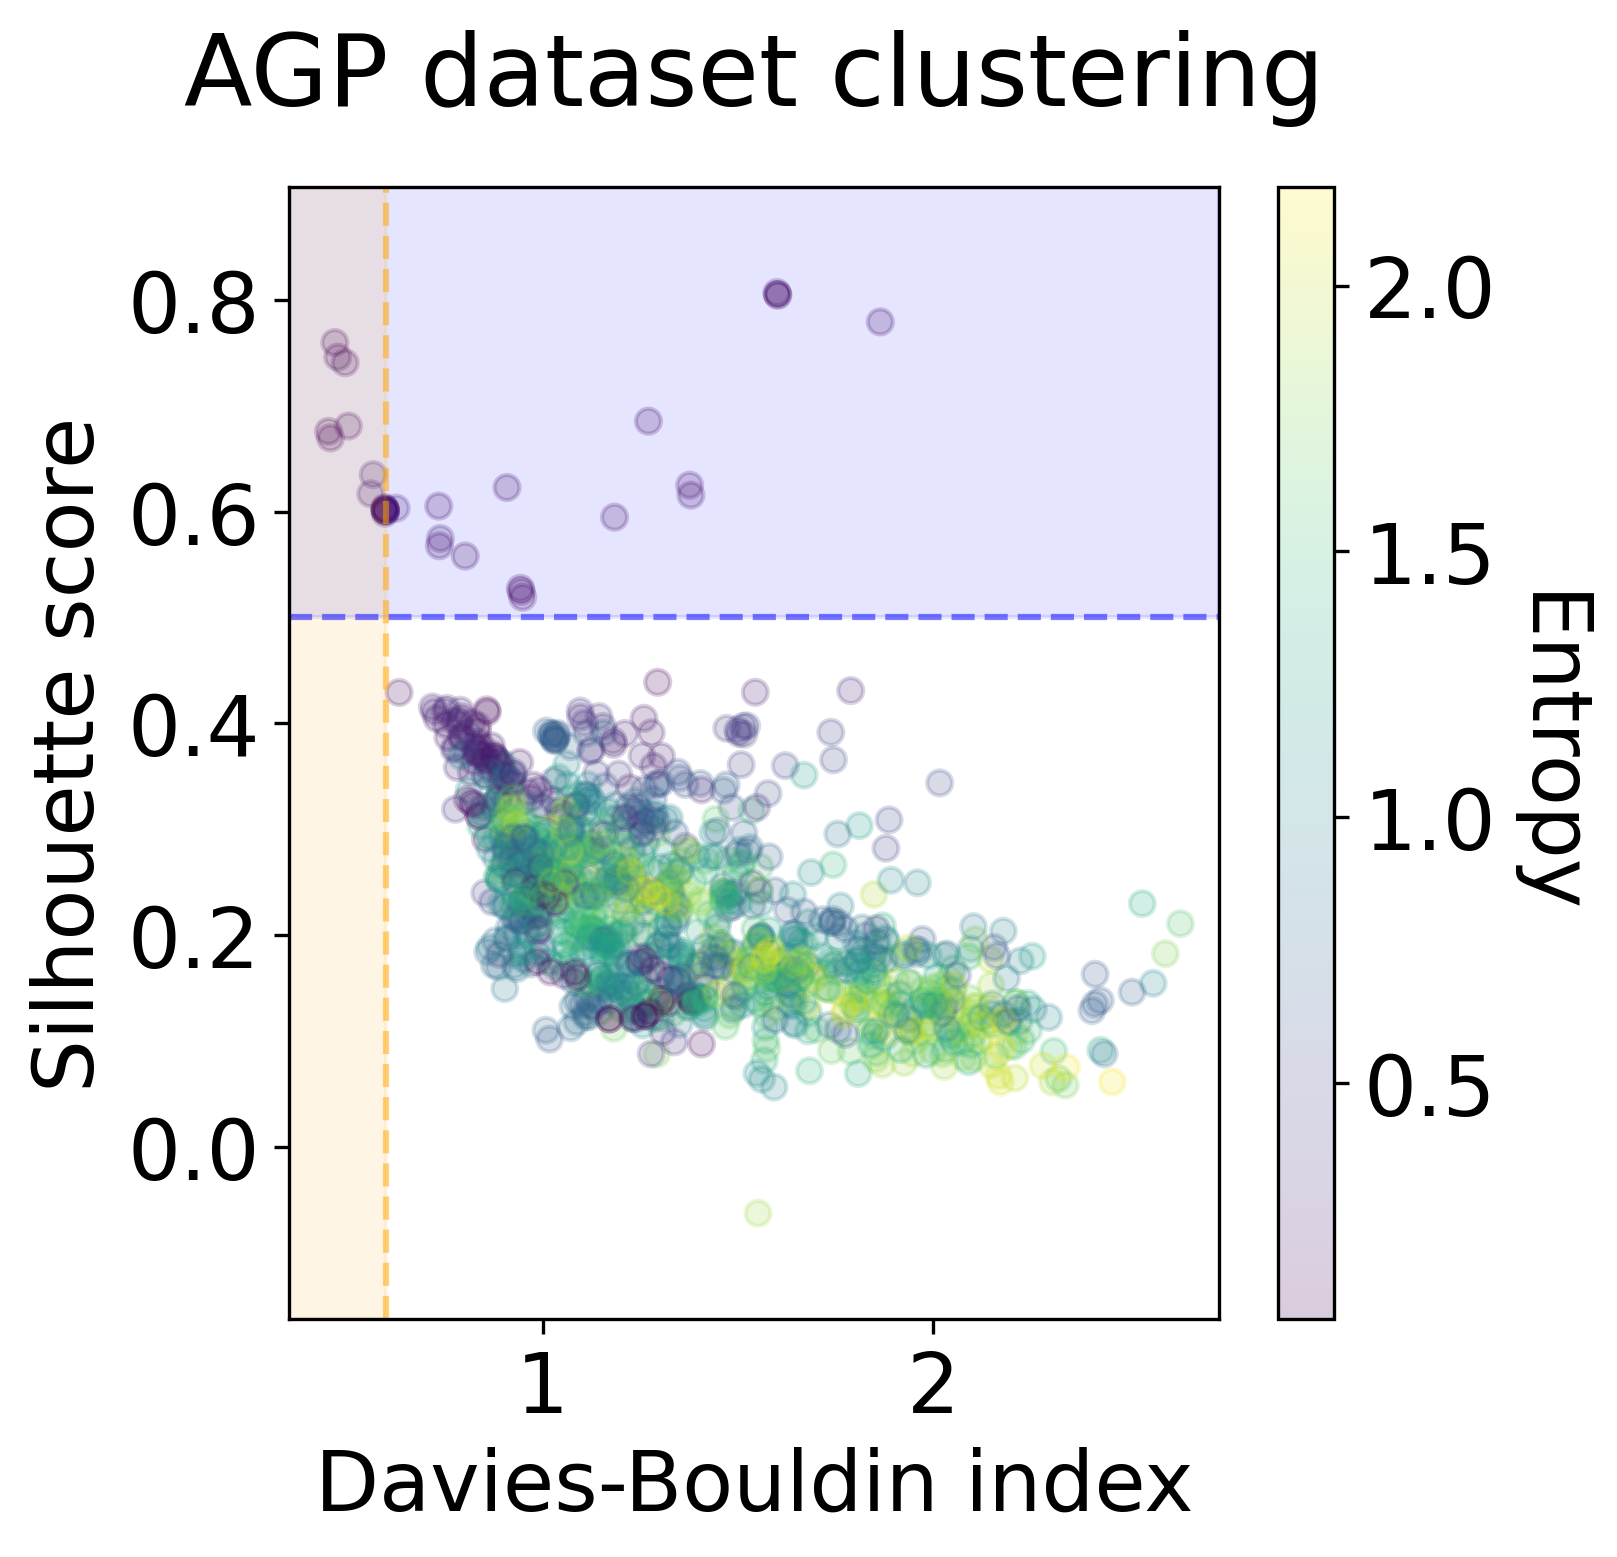

In [47]:
AGP_df = clustering_results_df_.query('dataset == "AGP"')

plot_clustering_scatter(AGP_df, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='AGP dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

In [48]:
selection_mask_AGP = (AGP_df['silh'] >= SILHOUETTE_THRESH) * (AGP_df['dbind'] <= DBIND_THRESHOLD)
AGP_df_selected = AGP_df[selection_mask_AGP]

idx = AGP_df_selected['entropy'].idxmax()
best_clustering = AGP_df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

For 'results/clustering_cpt-0.01_pat0.4' there are clusters in AGP_o, but data percentage remained is too small

In [49]:
Counter(y)

Counter({1: 243, 0: 8244, 2: 96})

In [50]:
X = data_embeddings[X_repr][f'AGP_{X_tax}'][df_mask]

lmnn = LMNN(n_components=2, 
            max_iter=500, 
            learn_rate=1e-2, 
            convergence_tol=1e-2, 
            random_state=42, 
            k=25, 
            init='pca',
            verbose=False)

# lmnn = PCA(n_components=2)
X = lmnn.fit_transform(X,y)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


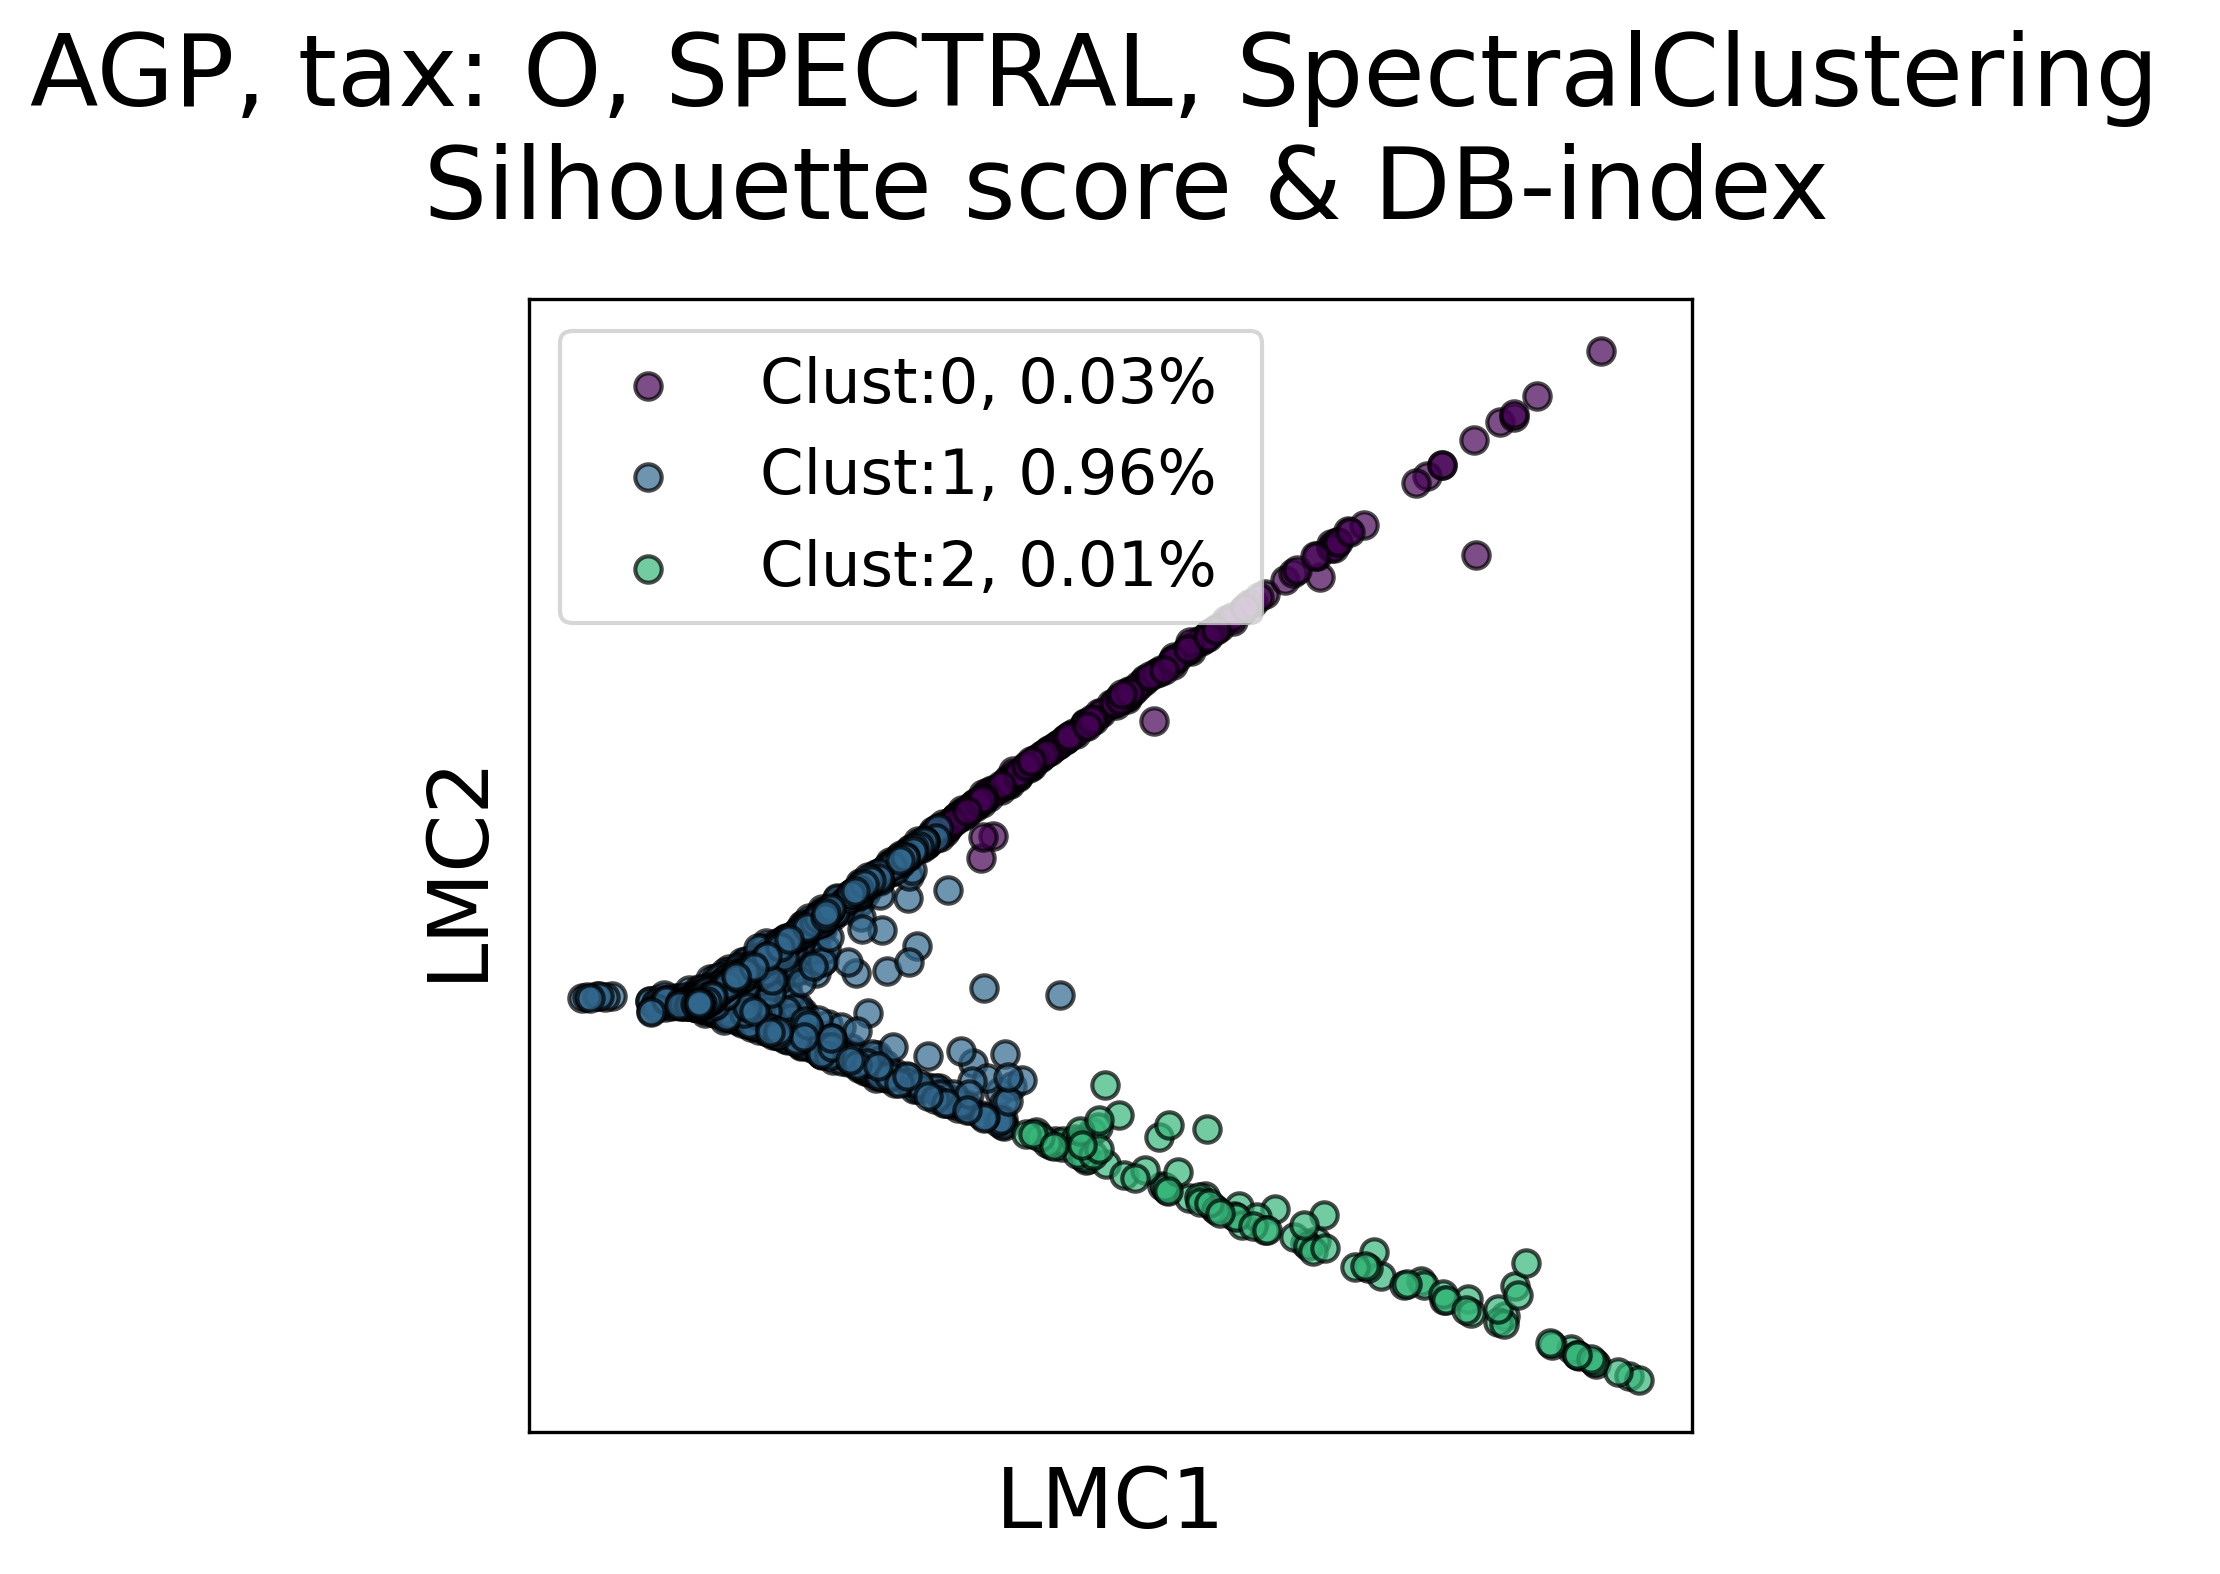

In [51]:
# likelihood = get_density(X,y)

plt.figure(figsize=(5,5), dpi=300)

# plt.imshow(likelihood[0], cmap='Purples', alpha=1)
# # plt.imshow(clusters_likelihoods[1], cmap='Greens', alpha=0.5)
# plt.imshow(likelihood[1], cmap='Oranges', alpha=1)
counter = Counter(y)

# starting from the largest cluster
for i,(y_k, n_k) in enumerate(counter.items()):
    
    if i == len(counter)-1:
        color_index = -1
    if i == 0:
        color_index = 0
    else:
        color_index = int(((i)/len(counter))*N_CMAP)
        
    color_k = plt.colormaps['viridis'].colors[color_index]
    
    perc = np.round(n_k / X.shape[0], 2)
    
    plt.scatter(
                coord_to_pix(X[:,0])[y==y_k], 
                coord_to_pix(X[:,1])[y==y_k],
                c=color_k,
                edgecolors='black',
                s=40,
                alpha=0.7,
                label=f'Clust:{i}, {perc}% '
               )
    
plt.legend(fontsize=15)
plt.xlabel('LMC1')
plt.ylabel('LMC2')
plt.xticks([])
plt.yticks([])
# plt.xlim(0, RES)
# plt.ylim(0, RES)
plt.title(f'AGP, tax: {X_tax.capitalize()}, {X_repr.upper()}, {X_cl_method} \n Silhouette score & DB-index')
plt.show()

In [52]:
# AGP_df_selected['hash'] = AGP_df_selected[['dataset','tax','representation','cl_method','n_cl']].astype(str).sum(1)
# idx = AGP_df_selected.groupby('hash')['entropy'].transform(max) == AGP_df_selected['entropy']
# AGP_df_selected[idx][['dataset', 'tax', 'representation', 'cl_method', 'n_cl', 'dbind','silh', 'dbcv', 'ps', 'entropy']].round(2)

## HMP

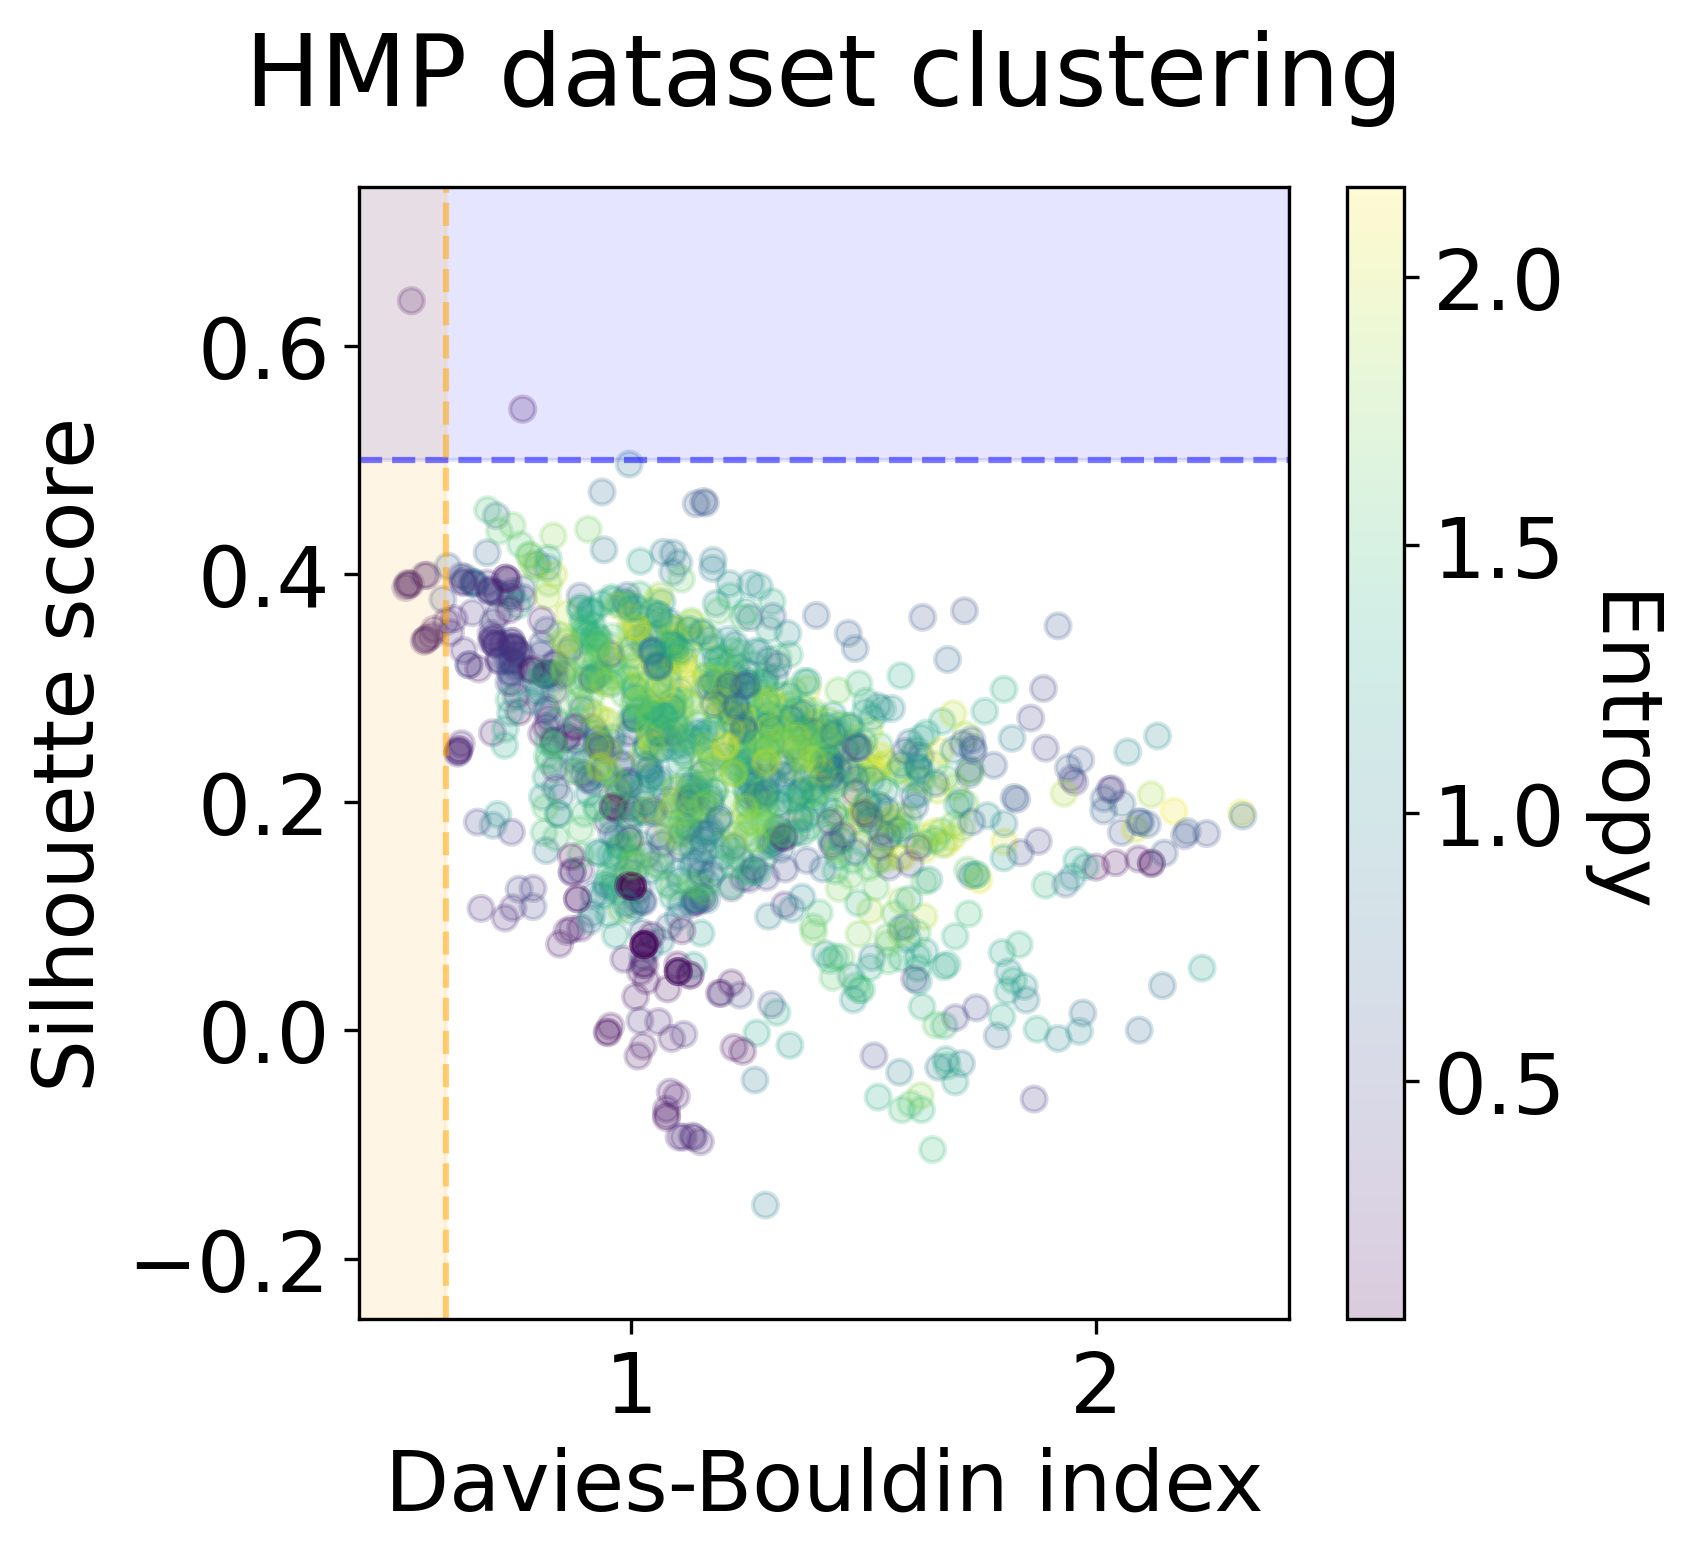

In [53]:
HMP_df = clustering_results_df_.query('dataset == "HMP"')
plot_clustering_scatter(HMP_df, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='HMP dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

In [54]:
selection_mask_HMP = (HMP_df['silh'] > SILHOUETTE_THRESH) * (HMP_df['dbind'] < DBIND_THRESHOLD)
HMP_df_selected = HMP_df[selection_mask_HMP]

idx = HMP_df_selected['entropy'].idxmax()
best_clustering = HMP_df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_embeddings[X_repr][f'HMP_{X_tax}'][df_mask]
lmnn = LMNN(n_components=2, 
            max_iter=500, 
            learn_rate=1e-4, 
            convergence_tol=1e-2, 
            random_state=42, 
            k=3, 
            verbose=False)

lmnn = PCA(n_components=2, random_state=42, whiten=True)

X = lmnn.fit_transform(X,y)

# X = X[:,:2]

# X = UMAP(n_components=2, random_state=42).fit_transform(X)
# likelihood = get_density(X,y)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


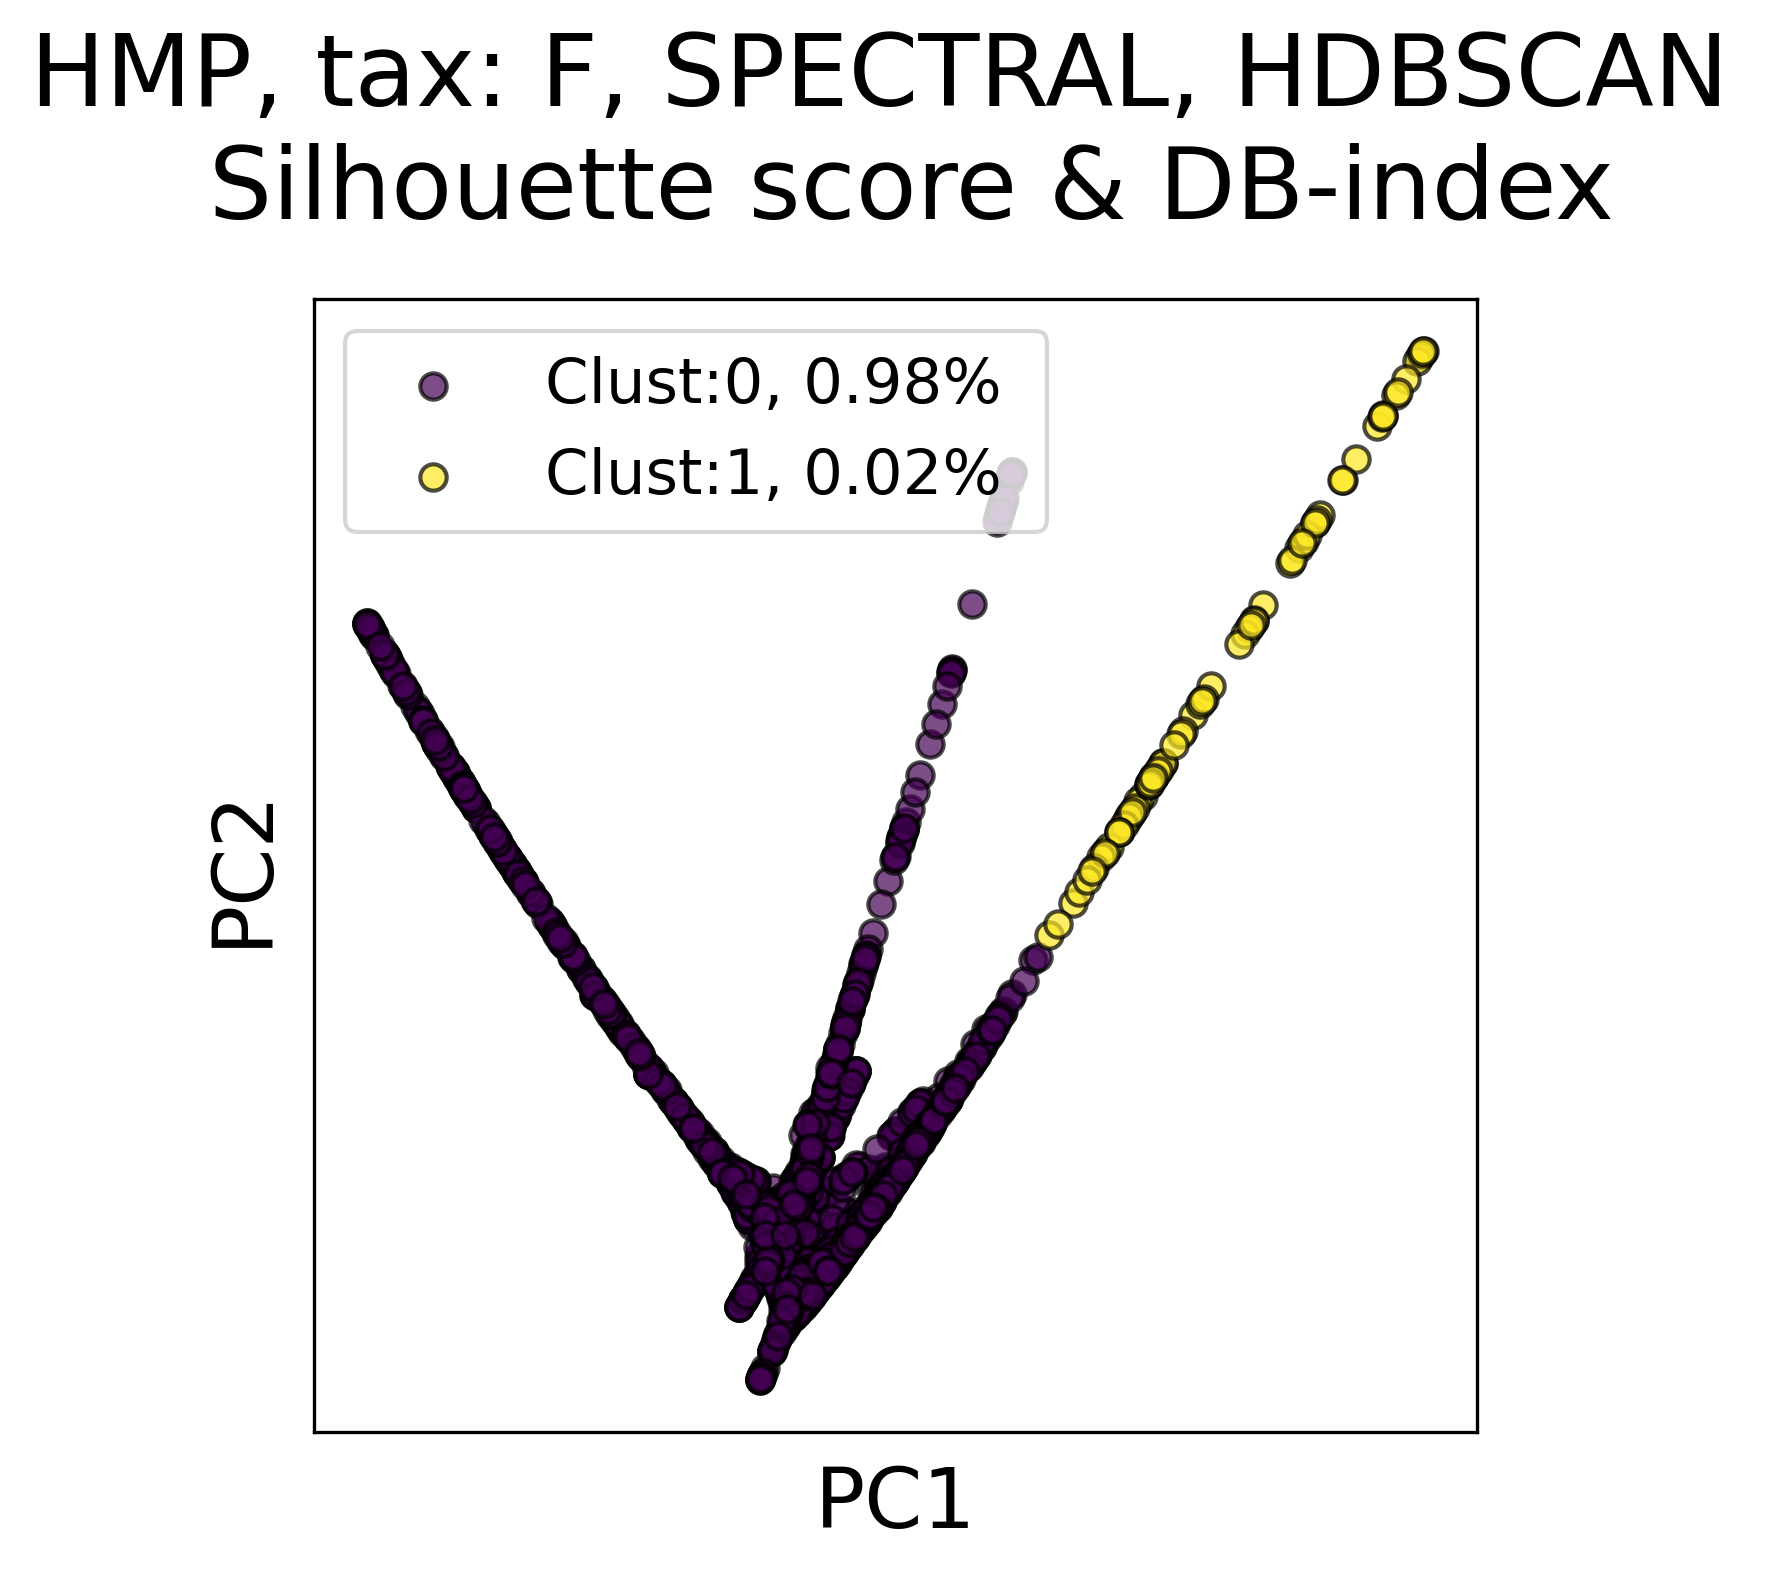

In [55]:
# likelihood = get_density(X,y)

plt.figure(figsize=(5,5), dpi=300)

# plt.imshow(likelihood[0], cmap='Purples', alpha=1)
# # plt.imshow(clusters_likelihoods[1], cmap='Greens', alpha=0.5)
# plt.imshow(likelihood[1], cmap='Oranges', alpha=1)
counter = Counter(y)

# starting from the largest cluster
for i,(y_k, n_k) in enumerate(counter.items()):
    
    color_index = -1 if i == 1 else 0
#     color_index = int(((i+1)/len(counter))*N_CMAP)
    color_k = plt.colormaps['viridis'].colors[color_index]
    
    perc = np.round(n_k / X.shape[0], 2)
    plt.scatter(
                coord_to_pix(X[:,0])[y==y_k], 
                coord_to_pix(X[:,1])[y==y_k],
                c=color_k,
                edgecolors='black',
                s=40,
                alpha=0.7,
                label=f'Clust:{i}, {perc}% '
               )
plt.legend(fontsize=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])
# plt.xlim(0, RES)
# plt.ylim(0, RES)
plt.title(f'HMP, tax: {X_tax.capitalize()}, {X_repr.upper()}, {X_cl_method} \n Silhouette score & DB-index')
plt.show()

# DBCV and Prediction Score, entropy coloring

## AGP

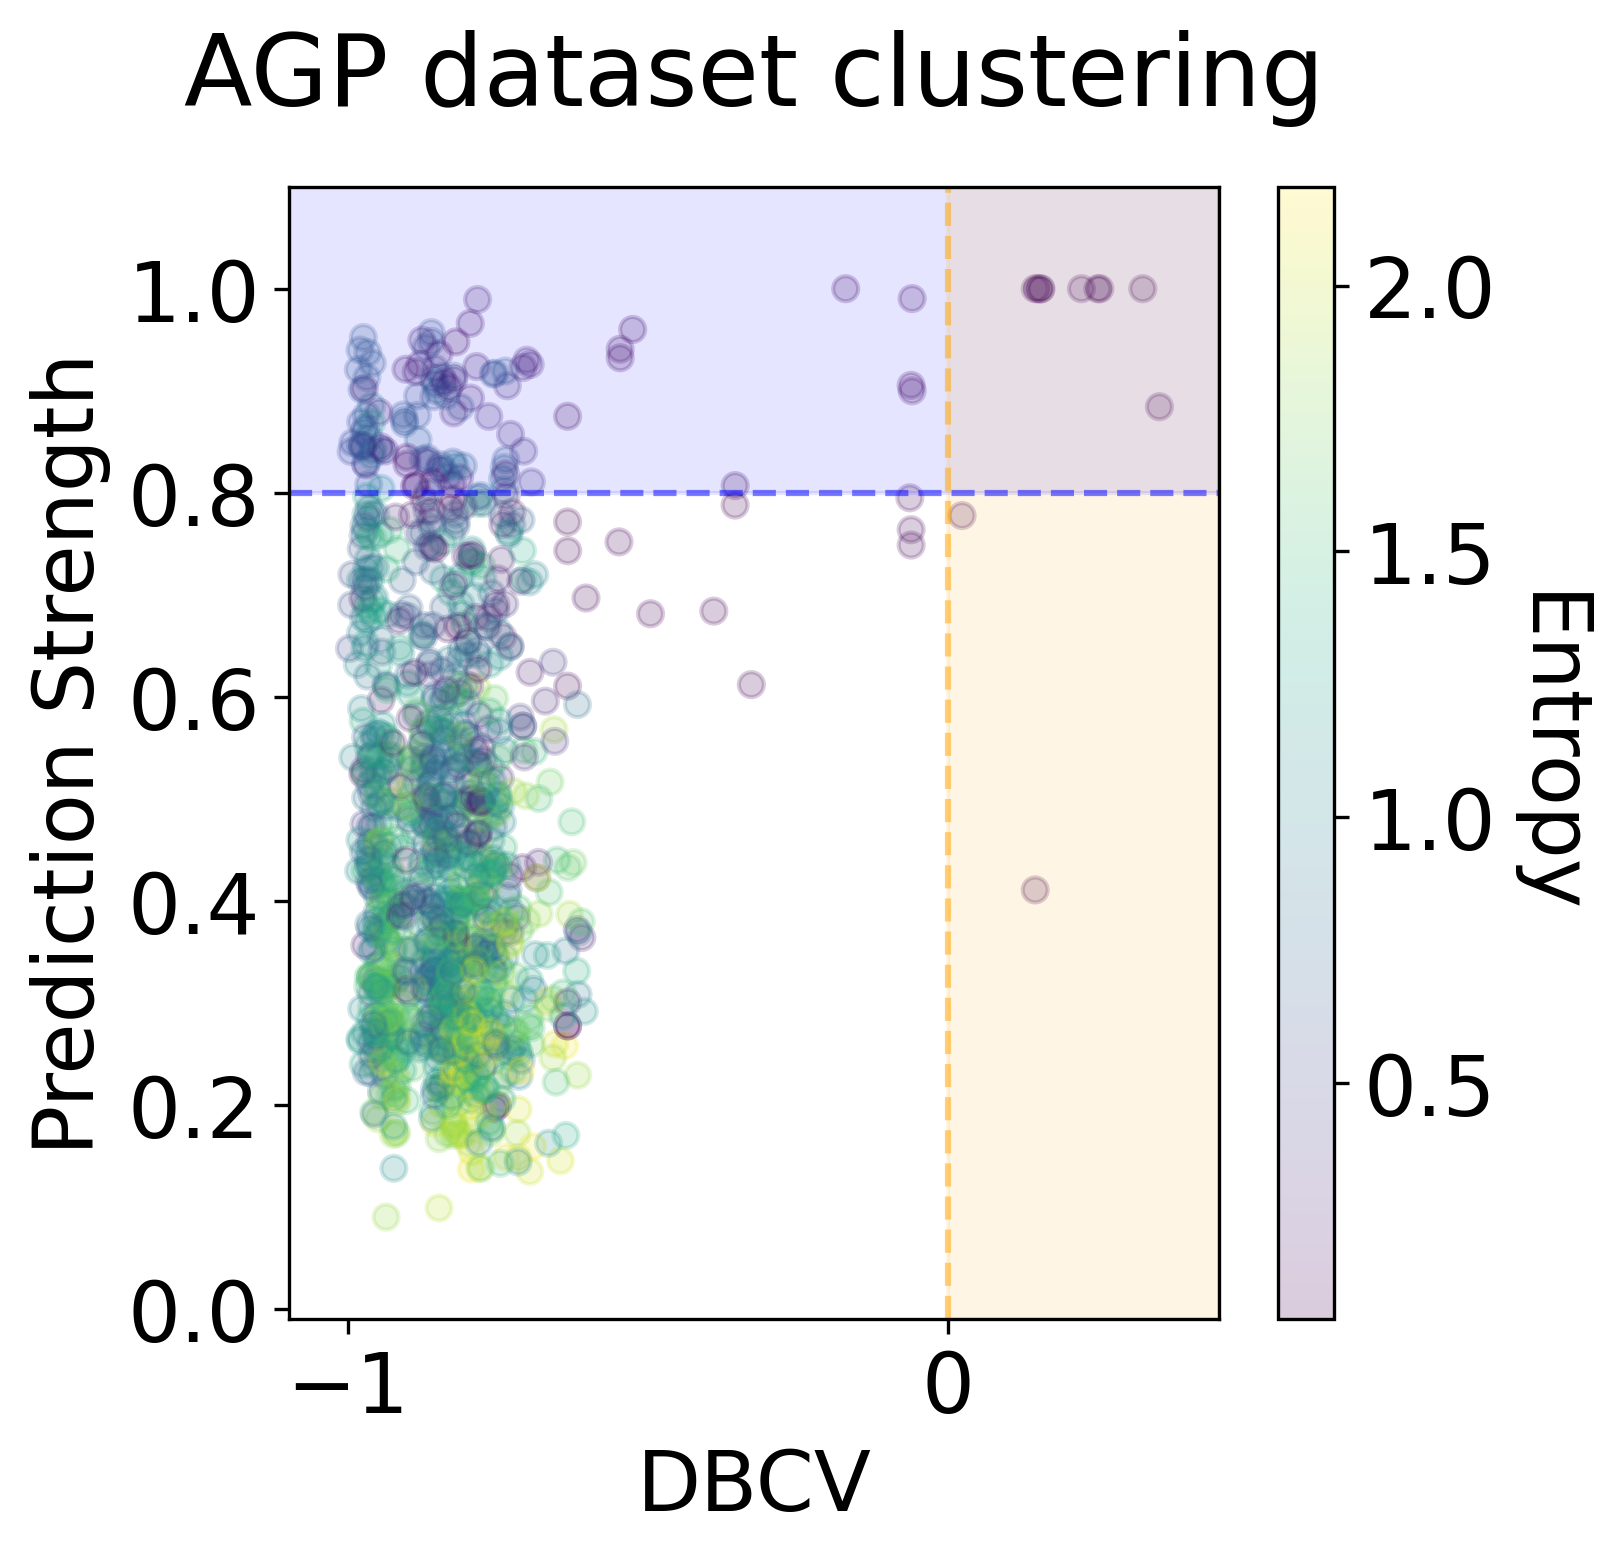

In [56]:
AGP_df = clustering_results_df_.query('dataset == "AGP"')

plot_clustering_scatter(AGP_df, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='AGP dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

In [57]:
selection_mask_AGP = (AGP_df['dbcv'] > DBCV_THRESHOLD) * (AGP_df['ps'] > PS_THRESHOLD)
AGP_df_selected = AGP_df[selection_mask_AGP]

idx = AGP_df_selected['entropy'].idxmax()
best_clustering = AGP_df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']


X = data_embeddings[X_repr][f'AGP_{X_tax}'][df_mask]
# X = UMAP(n_components=2, random_state=42).fit_transform(X)

lmnn = LMNN(n_components=2, 
            max_iter=500, 
            learn_rate=1e-4, 
            convergence_tol=1e-2, 
            random_state=42, 
            k=25, 
            verbose=False)

# lmnn = PCA(n_components=2, random_state=42)

X = lmnn.fit_transform(X,y)

# likelihood = get_density(X,y)

# plt.figure(figsize=(5,5), dpi=300)

# plt.imshow(likelihood[0], cmap='Purples', alpha=1)
# plt.imshow(likelihood[1], cmap='Oranges', alpha=0.3)

# plt.scatter(
#             coord_to_pix(X[:,0]), 
#             coord_to_pix(X[:,1]),
#             c=y,
#             edgecolors='black',
#             s=40,
#             alpha=0.7
#            )

# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.xticks([])
# plt.yticks([])
# # plt.xlim(0, RES)
# # plt.ylim(0, RES)
# plt.title(f'AGP, tax: {X_tax.capitalize()}, {X_repr.upper()}, {X_cl_method} \n DBCV & Prediction scores')

# plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


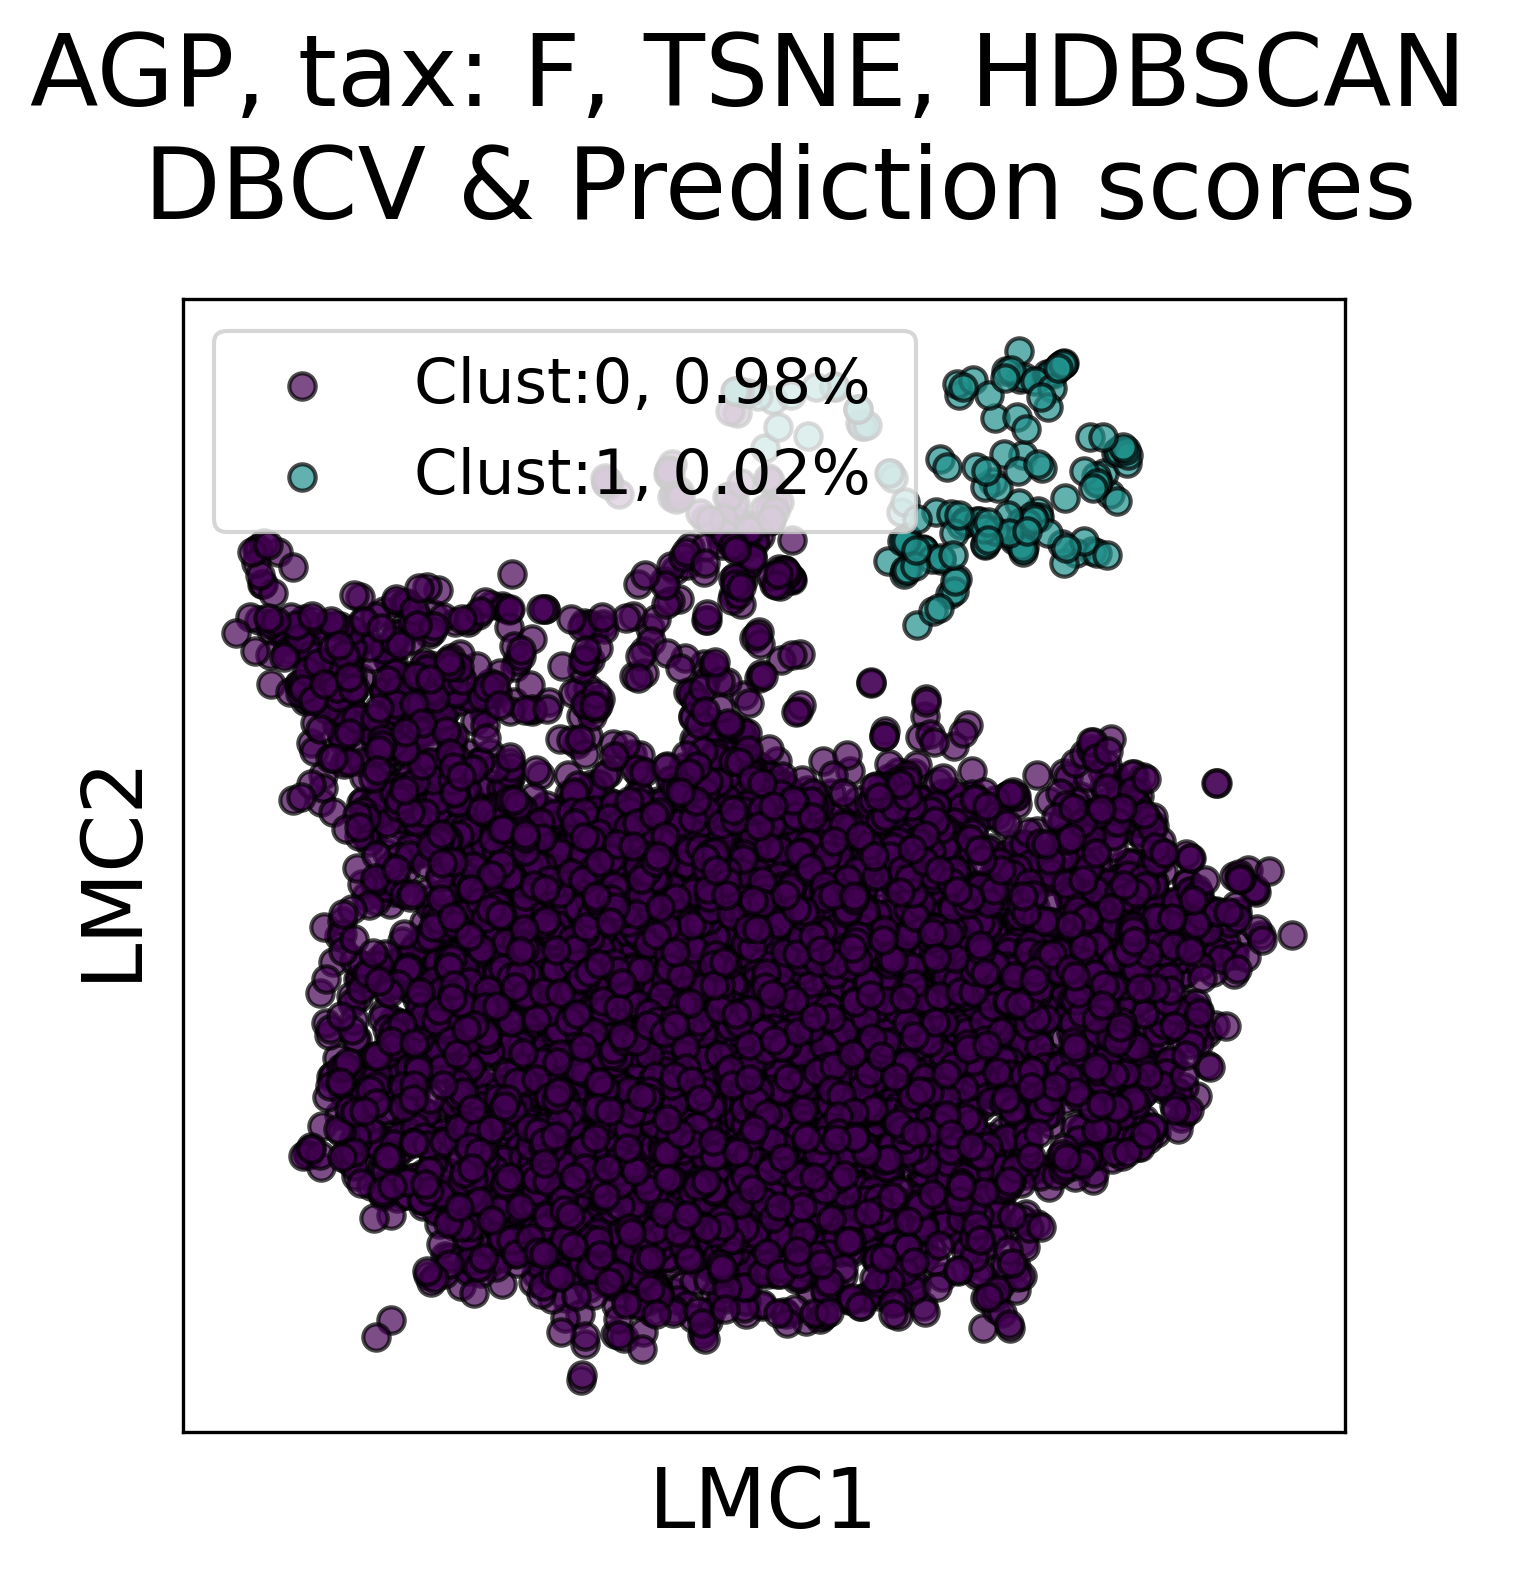

In [58]:
# likelihood = get_density(X,y)

plt.figure(figsize=(5,5), dpi=300)

# plt.imshow(likelihood[0], cmap='Purples', alpha=1)
# # plt.imshow(clusters_likelihoods[1], cmap='Greens', alpha=0.5)
# plt.imshow(likelihood[1], cmap='Oranges', alpha=1)
counter = Counter(y)

# starting from the largest cluster
for i,(y_k, n_k) in enumerate(counter.items()):
    
    if i == len(counter)-1:
        color_index = -1
    if i == 0:
        color_index = 0
    else:
        color_index = int(((i)/len(counter))*N_CMAP)
  
    color_k = plt.colormaps['viridis'].colors[color_index]
    
    perc = np.round(n_k / X.shape[0], 2)
    plt.scatter(
                coord_to_pix(X[:,0])[y==y_k], 
                coord_to_pix(X[:,1])[y==y_k],
                c=color_k,
                edgecolors='black',
                s=40,
                alpha=0.7,
                label=f'Clust:{i}, {perc}% '
               )
plt.legend(fontsize=15)
plt.xlabel('LMC1')
plt.ylabel('LMC2')
plt.xticks([])
plt.yticks([])
# plt.xlim(0, RES)
# plt.ylim(0, RES)
plt.title(f'AGP, tax: {X_tax.capitalize()}, {X_repr.upper()}, {X_cl_method} \n DBCV & Prediction scores')
plt.show()

In [59]:
# AGP_df_selected['hash'] = AGP_df_selected[['dataset','tax','representation','cl_method','n_cl']].astype(str).sum(1)
# idx = AGP_df_selected.groupby('hash')['entropy'].transform(max) == AGP_df_selected['entropy']
# AGP_df_selected[idx][['dataset', 'tax', 'representation', 'cl_method', 'n_cl', 'dbind','silh', 'dbcv', 'ps', 'entropy']].round(2)

## HMP

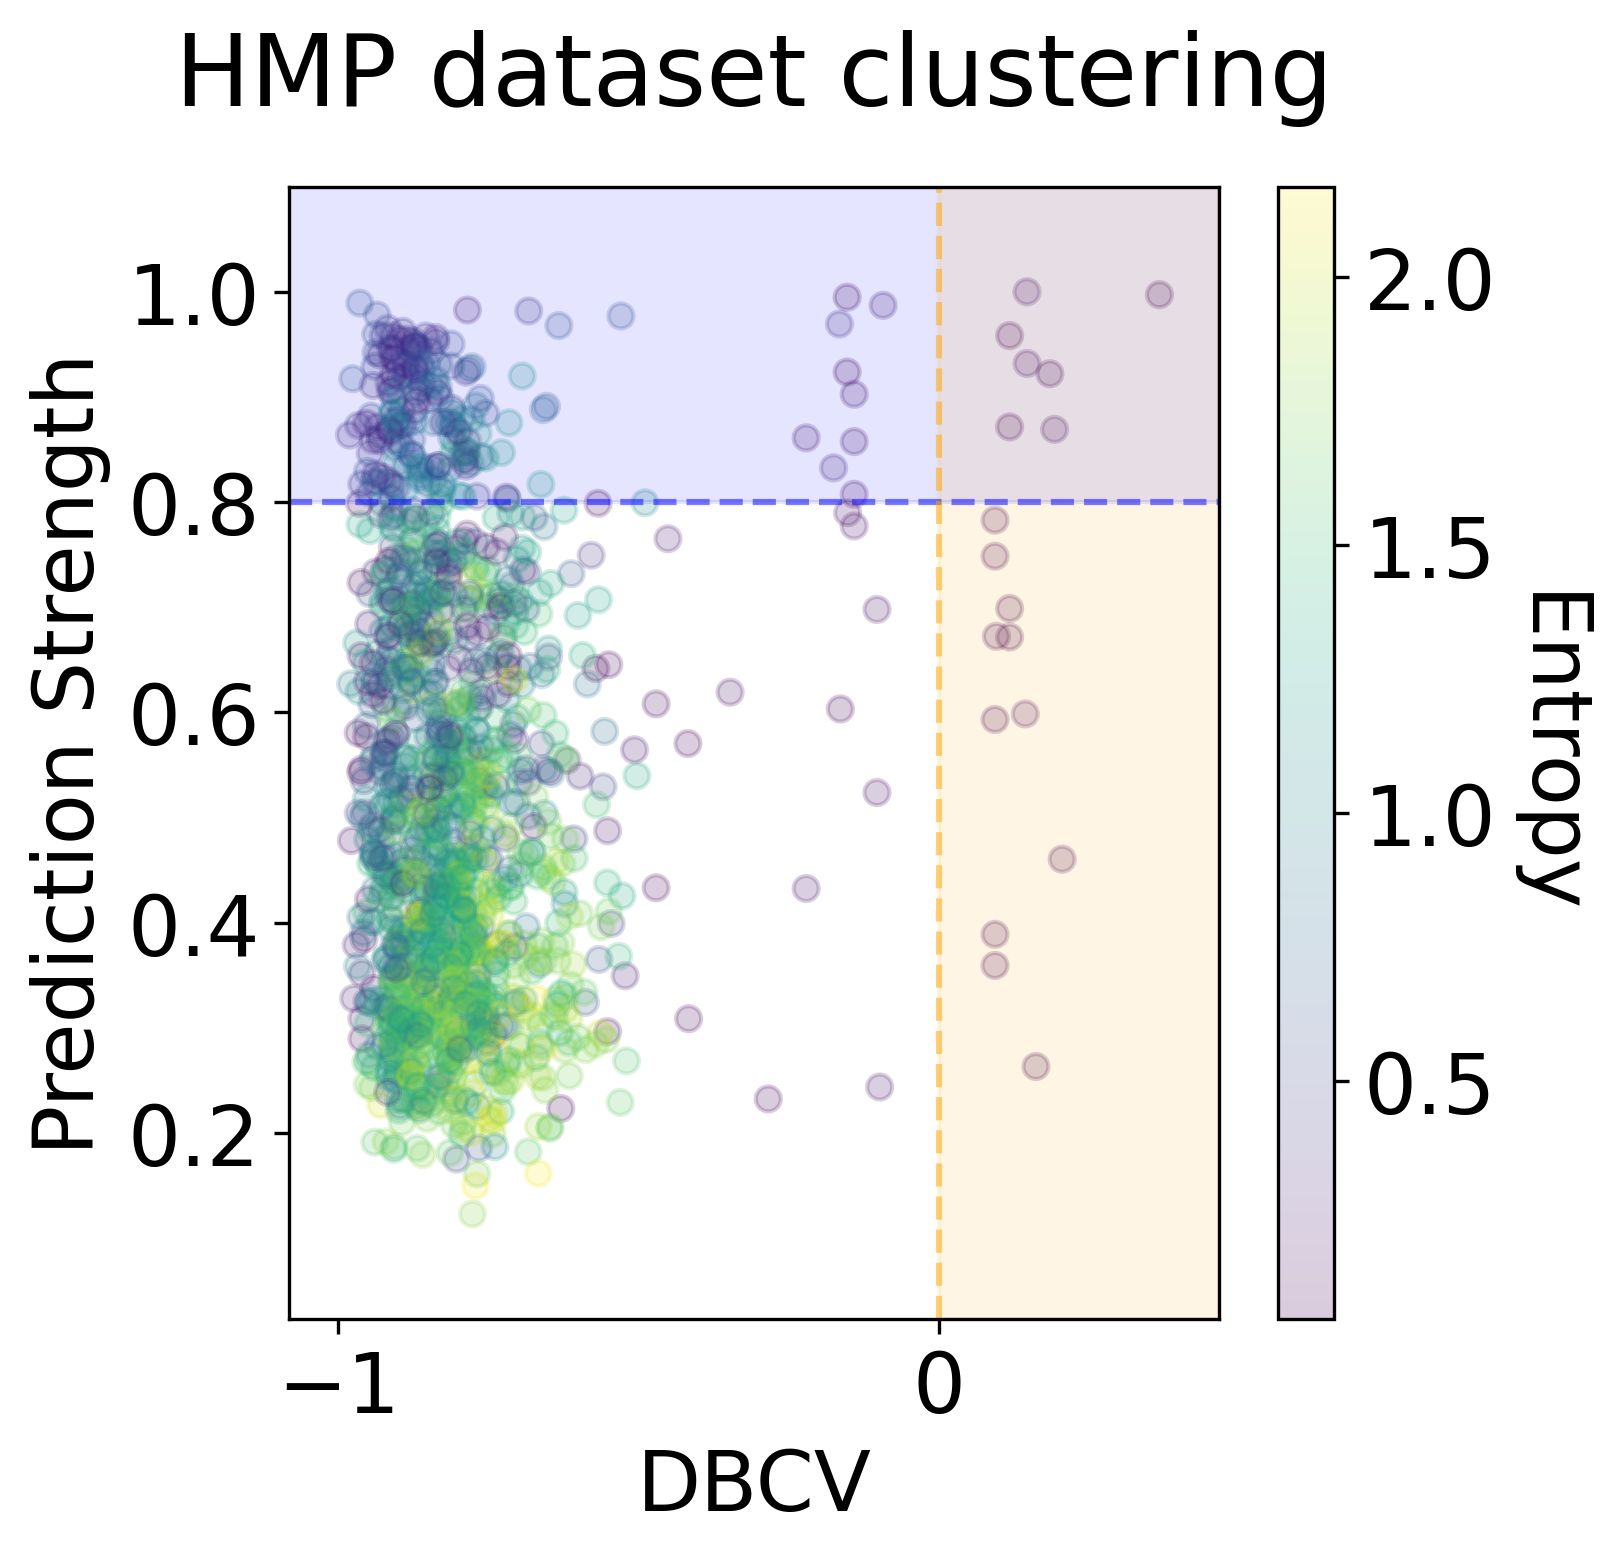

In [60]:
HMP_df = clustering_results_df_.query('dataset == "HMP"')
plot_clustering_scatter(HMP_df, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='HMP dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

In [61]:
selection_mask_HMP = (HMP_df['dbcv'] > DBCV_THRESHOLD) * (HMP_df['ps'] > PS_THRESHOLD)
HMP_df_selected = HMP_df[selection_mask_HMP]

idx = HMP_df_selected['entropy'].idxmax()
best_clustering = HMP_df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_embeddings[X_repr][f'HMP_{X_tax}'][df_mask]

lmnn = LMNN(n_components=2, 
            max_iter=1000, 
            learn_rate=1e-3, 
            convergence_tol=1e-2, 
            random_state=42, 
            k=25, 
            verbose=False)
# lmnn = PCA(n_components=2, random_state=42)

X = lmnn.fit_transform(X,y)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


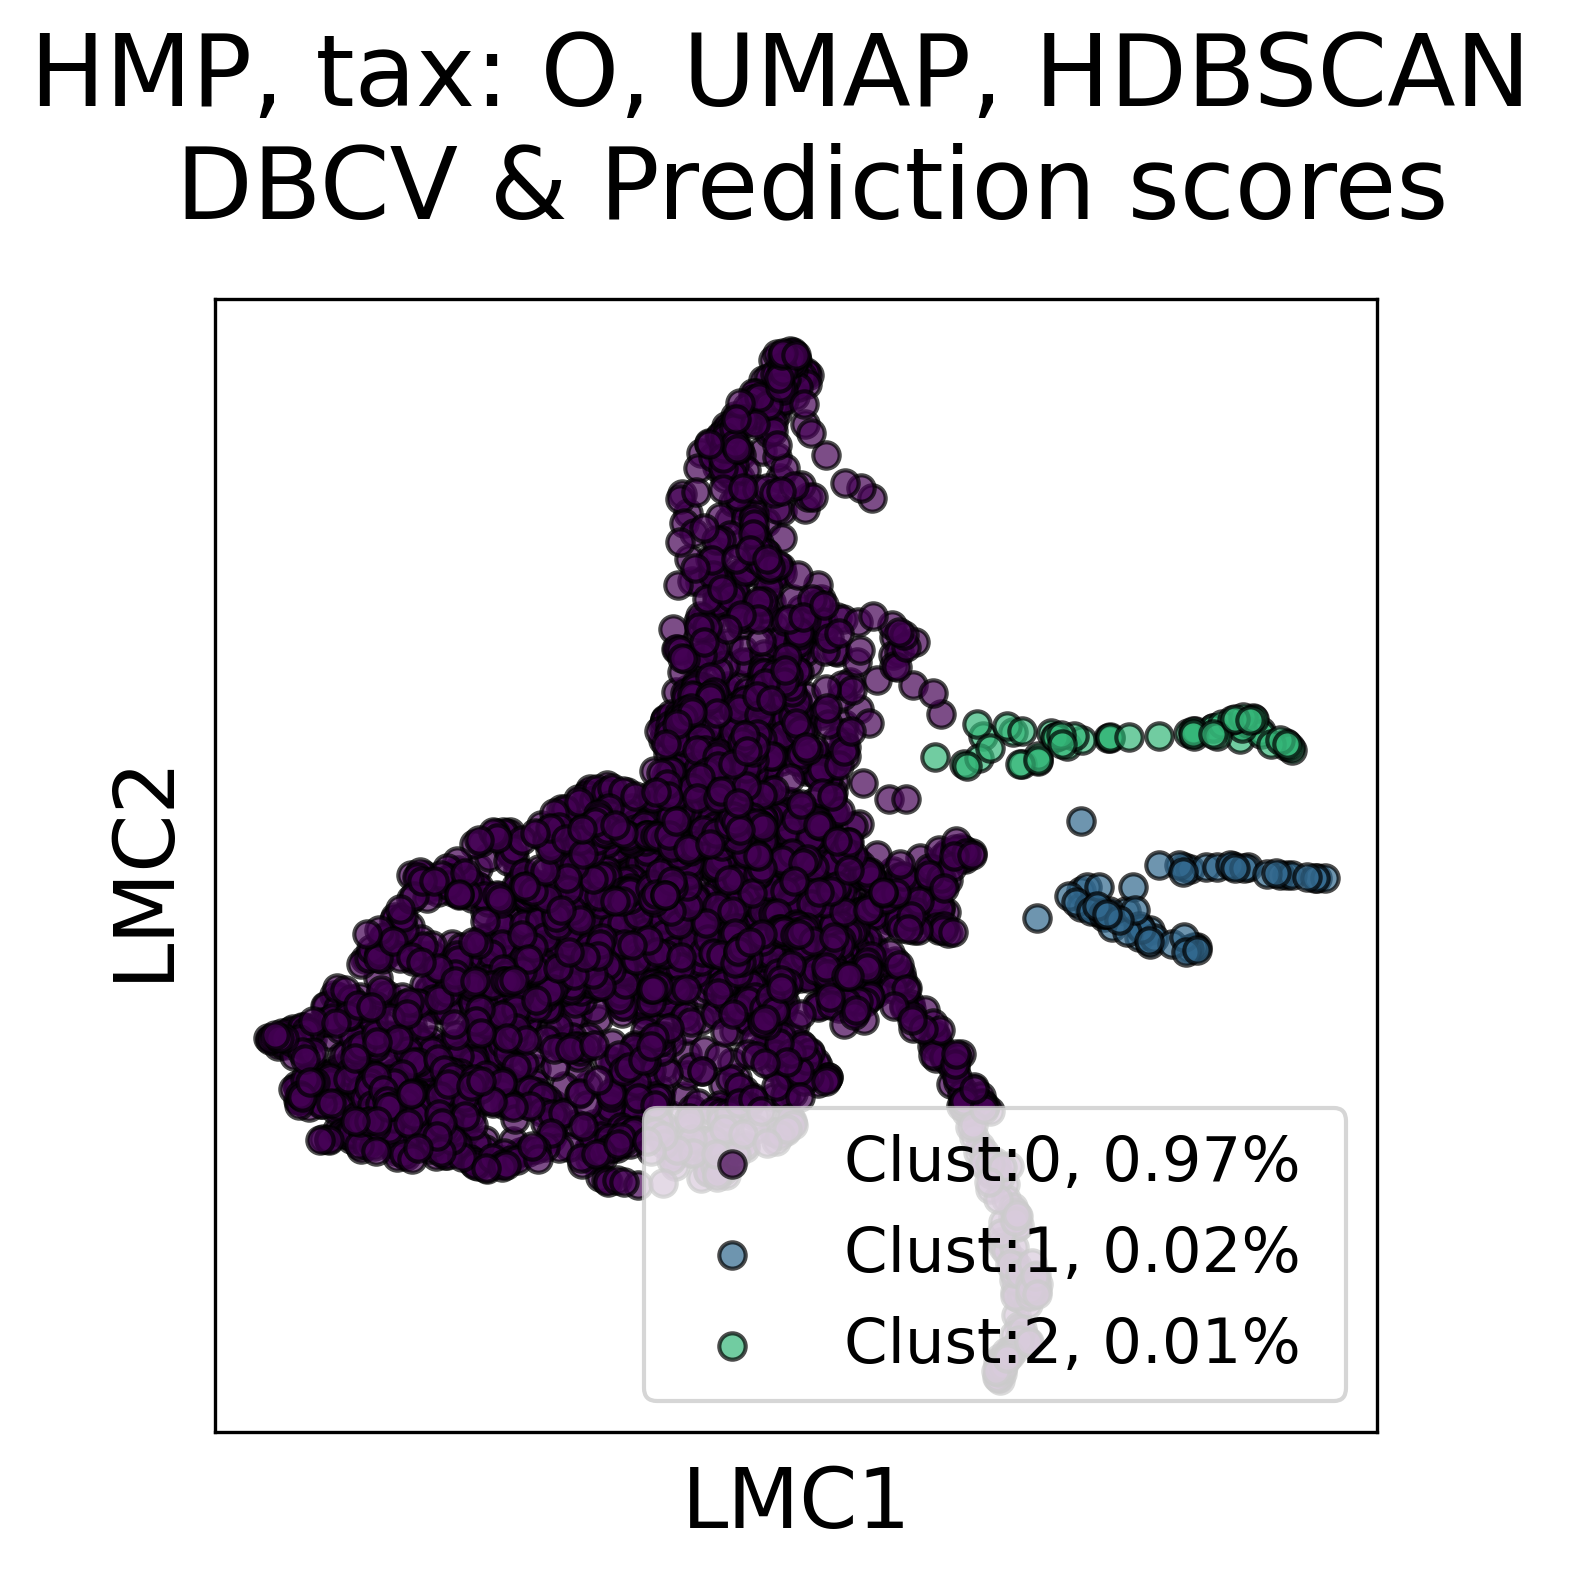

In [62]:
# likelihood = get_density(X,y)

plt.figure(figsize=(5,5), dpi=300)

# plt.imshow(likelihood[0], cmap='Purples', alpha=1)
# # plt.imshow(clusters_likelihoods[1], cmap='Greens', alpha=0.5)
# plt.imshow(likelihood[1], cmap='Oranges', alpha=1)
counter = Counter(y)

# starting from the largest cluster
for i,(y_k, n_k) in enumerate(counter.items()):
    
    if i == len(counter)-1:
        color_index = -1
    if i == 0:
        color_index = 0
    else:
        color_index = int(((i)/len(counter))*N_CMAP)
        
    color_k = plt.colormaps['viridis'].colors[color_index]
    
    perc = np.round(n_k / X.shape[0], 2)
    plt.scatter(
                coord_to_pix(X[:,0])[y==y_k], 
                coord_to_pix(X[:,1])[y==y_k],
                c=color_k,
                edgecolors='black',
                s=40,
                alpha=0.7,
                label=f'Clust:{i}, {perc}% '
               )
plt.legend(fontsize=15)
plt.xlabel('LMC1')
plt.ylabel('LMC2')
plt.xticks([])
plt.yticks([])
# plt.xlim(0, RES)
# plt.ylim(0, RES)
plt.title(f'HMP, tax: {X_tax.capitalize()}, {X_repr.upper()}, {X_cl_method} \n DBCV & Prediction scores')
plt.show()

In [531]:
# HMP_df_selected['hash'] = HMP_df_selected[['dataset','tax','representation','cl_method','n_cl']].astype(str).sum(1)
# idx = HMP_df_selected.groupby('hash')['entropy'].transform(max) == HMP_df_selected['entropy']
# HMP_df_selected[idx][['dataset', 'tax', 'representation', 'cl_method', 'n_cl', 'dbind','silh', 'dbcv', 'ps', 'entropy']].round(2)